# Essential portfolio math

This brief chapter will cover the type of statistics that we often see when looking at **portfolios**. Much of this material is covered in various DataCamp exercises. Pieces, such as skewness and kurtosis, are also covered in **Chapter 13 of our textbook**. 

This material will have us thinking about **portfolio construction**.

What is **portfolio construction**? Choosing and sizing the various trades to achieve a good trade-off between risk and expected return.

1. Diversification
2. Position limits and risk limits: At the level of securities, asset classes, and overall portfolio. 
3. Larger bets on higher conviction trade.
4. Size bets in terms of risk
5. Correlations matter
  For a long position, correlation with other longs is bad, corr. with shorts is good
  Powerful to go long/short within each industry, diversify across industries
  Can use ETFs and futures to “hedge” out sector and market exposure
6. Resize positions according to forward-looking risk and conviction

We'll start by bringing in some **monthly hedge fund return data**. We'll calculate some portfolio returns, using assumed weights. We'll then move on to portfolio-level **variance and standard deviation**. We'll see how to **annualize returns and volatility**. We'll look at other risk measures, like **skewness** and **kurtosis**. We'll see **Sharpe** and **Sortino** ratios. Finally, we'll make a graph for the max drawdown of our strategy.

These ideas will get us thinking about portfolios, trading strategies, risk management, and portfolio optimization.

The formulas are **must knows** for finance folks! For example, you need these on CFA Level 1.


In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import janitor
from janitor import clean_names

hf = pd.read_excel('https://raw.githubusercontent.com/aaiken1/fin-data-analysis-python/main/data/hf_rets.xlsx',
                  index_col=0, parse_dates=True)  

hf = hf.clean_names()

hf.describe()

,rf,mkt_rf,smb,hml,umd,ln_sh_eq_hedge_fund_usd,eq_mkt_ntr_hedge_fund_usd,ded_sh_bs_hedge_fund_usd,global_mac_hedge_fund_usd,mngd_fut_hedge_fund_usd,emg_mkts_hedge_fund_usd,evnt_drvn_hedge_fund_usd,_cnvrt_arb_hedge_fund_usd,fx_inc_arb_hedge_fund_usd,djcs_hedge_fund_usd
count,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000
mean,0.002536,0.005089,0.002121,0.002133,0.004886,0.007535,0.004410,-0.002217,0.009594,0.005108,0.006656,0.007360,0.006129,0.004366,0.007011
std,0.001742,0.047007,0.035581,0.033738,0.054827,0.028745,0.029770,0.049144,0.028000,0.033738,0.042929,0.018291,0.019981,0.016485,0.021820
min,0.000000,-0.185500,-0.166200,-0.128700,-0.347500,-0.114806,-0.404590,-0.112825,-0.115652,-0.093702,-0.230716,-0.118201,-0.126007,-0.140442,-0.075948
25%,0.000900,-0.023225,-0.019750,-0.015275,-0.011225,-0.008805,0.001250,-0.033677,-0.001949,-0.018947,-0.012924,0.000110,-0.000482,0.001716,-0.002376
50%,0.003000,0.011550,-0.001450,0.002150,0.006300,0.007663,0.006715,-0.007478,0.010404,0.003235,0.012111,0.009848,0.009817,0.007131,0.007447
75%,0.004100,0.035600,0.023025,0.017750,0.030425,0.023168,0.012581,0.029215,0.021420,0.028790,0.028144,0.018590,0.014712,0.011529,0.018074
max,0.005600,0.115300,0.220600,0.138800,0.184000,0.129913,0.036573,0.226661,0.105808,0.099063,0.164018,0.042168,0.058055,0.043331,0.085117


There's a lot there, so let's just keep four different columns. These columns represent the average monthly return for that hedge fund type. I'm keeping long/short equity, equity market neutral, global macro, managed futures.

Long/short equity funds do what that says - they go long and short stocks, generally keeping their market beta less than one. Equity market neutral might aim for a beta of zero, but usually have more exposure than that. They are trying to get rid of their risk exposures and just earn alpha from security mispricings. Global macro funds make trades based on broad market trends, currencies, and other markets affected by macro events, like inflation or economic growth. They don't buy or sell individual securities and often use futures contracts to get their exposures. Finally, managed futures are similar, but tend to follow trend-following strategies. 

You'll see more on these ideas in the factor model notes.

In [56]:
rets = hf.iloc[:,[5, 6, 8, 9]]
rets

,ln_sh_eq_hedge_fund_usd,eq_mkt_ntr_hedge_fund_usd,global_mac_hedge_fund_usd,mngd_fut_hedge_fund_usd
date,,,,
1994-01-31,0.011733,-0.005467,0.001433,0.001933
1994-02-28,-0.025011,0.002106,-0.056811,0.011667
1994-03-31,-0.039114,-0.002514,-0.042854,0.025923
1994-04-29,-0.015720,0.002397,-0.016033,0.008437
1994-05-31,0.005550,-0.001229,0.037839,0.007497
...,...,...,...,...
2012-02-29,0.026418,0.013335,0.007852,0.012039
2012-03-30,0.004998,-0.001553,-0.004271,-0.029648
2012-04-30,-0.004680,-0.004139,-0.002522,0.004299


## Portfolio-level returns

Let's define an array of weights. We'll put 25% of our money into each style category. This isn't actually an investable strategy, since you can't invest in the average long/short equity fund!

In [57]:
wgts = np.array([0.25, 0.25, 0.25, 0.25])

We can find the monthly means for each strategy.

In [41]:
monthy_rets_avg = rets.mean()
monthy_rets_avg

ln_sh_eq_hedge_fund_usd      0.007535
eq_mkt_ntr_hedge_fund_usd    0.004410
global_mac_hedge_fund_usd    0.009594
mngd_fut_hedge_fund_usd      0.005108
dtype: float64

We can also see what our equally-weighted portfolio would have done per month over that time period.

In [58]:
hf_port_ret = np.sum(monthy_rets_avg*wgts)
hf_port_ret

0.0066618444208333735

Let's weight each month's returns by our weights so that we can then calculate monthly portfolio returns.

In [43]:
weighted_returns = (wgts * rets)

I'm calculating monthly returns by summing up across each row. That's the `axis=1` argument. I'm then naming this series *port_ret*.

In [44]:
port_ret = weighted_returns.sum(axis=1).rename('port_ret')


I'll join my portfolio returns to the monthly fund returns. There should be the same number of portfolio returns as individual hedge fund returns.

In [45]:
rets_with_port = rets.join(port_ret)

And, I can calculate cumulative returns and then graph them. 

In [46]:
monthly_cum_rets=(1+rets_with_port).cumprod()

<AxesSubplot:xlabel='date'>

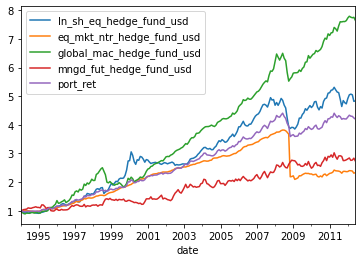

In [47]:
monthly_cum_rets.plot()
 

Yikes! Check out the orange line - equity market neutral funds aren't necessarily very market neutral!

## Risk measures at the portfolio-level

As you know from your investments class, the variance of a portfolio is **not** the average variance of the assets in the portfolio. We need to take into account the effects of **diversification**. For example, here's the formula for the variance of a portfolio with two assets. We need weights, variances, and the covariance between the two.

\begin{align}
\sigma^2_p = w^2_1 \sigma^2_1 + w^2_2 \sigma^2_2 + 2 w_1 w_2 \sigma^2_{1,2}
\end{align}

$\sigma^2_{1,2}$ is the **covariance** between the two assets. 

This formula generalizes for **any number of assets**. 

\begin{align}
\sigma^2_p = w^T \Sigma w
\end{align}

where $w$ is a **vector** containing all of our portfolio weights and $\Sigma$ is the variance-covariance matrix for our assets. The "T" means the matrix operation **transpose**. This is necessary for the matrix multiplication. 

Let's use Python to find the variance-covariance matrix. There are variances along with diagonal of the matrix and covariance terms **between assets** in the off-diagonals. Note that upper-right and lower-left of the matrix are identical. This is because the covariance between Asset 1 and Asset 2 is the same as the covariance between Asset 2 and Asset 1. 

In [48]:
cov_matrix = rets.cov()
cov_matrix

,ln_sh_eq_hedge_fund_usd,eq_mkt_ntr_hedge_fund_usd,global_mac_hedge_fund_usd,mngd_fut_hedge_fund_usd
ln_sh_eq_hedge_fund_usd,0.000826,0.000192,0.000362,0.000066
eq_mkt_ntr_hedge_fund_usd,0.000192,0.000886,0.000069,0.000005
global_mac_hedge_fund_usd,0.000362,0.000069,0.000784,0.000283
mngd_fut_hedge_fund_usd,0.000066,0.000005,0.000283,0.001138


Let's use our general formula, our weights, and the cov matrix to find **portfolio variance**. We'll use `np.dot()` from `numpy` to do the dot product. This is like **mmult** in Excel. The `.T` transposes, or flips, the vector of returns so that we can multiply. 

In [50]:
port_variance = np.dot(wgts.T, np.dot(cov_matrix, wgts))
port_variance

0.00034955786030628624

Here's a [refresher on matrix multiplication](https://www.mathsisfun.com/algebra/matrix-multiplying.html) in case you need it.

Portfolio standard deviation is, of course, just the square root of variance. We can use `np.sqrt()`. 

In [51]:
port_stddev = np.sqrt(np.dot(wgts.T, np.dot(cov_matrix, wgts)))
print(str(np.round(port_stddev, 3) * 100) + '%')

1.9%


## Skewness and kurtosis

We'll look more at the distribution of asset returns when we get to a more formal treatment of risk management. But, for now, we need to know that asset returns, like stocks, and even portfolio returns, like those of a hedge fund, are not typically normally distributed. They "lean", or have **skewness**. That skewness can be either positive or negative, depending on the strategy. They also have **kurtosis**, or "fat tails". This means that there are more extreme returns than you would expect if they followed a normal distribution.

It is easy to find both in Python.

In [59]:
rets_with_port.skew()

ln_sh_eq_hedge_fund_usd      -0.012623
eq_mkt_ntr_hedge_fund_usd   -11.866451
global_mac_hedge_fund_usd     0.016477
mngd_fut_hedge_fund_usd       0.026489
port_ret                     -0.386969
dtype: float64

In [60]:
rets_with_port.kurt()

ln_sh_eq_hedge_fund_usd        3.186683
eq_mkt_ntr_hedge_fund_usd    162.760371
global_mac_hedge_fund_usd      3.888268
mngd_fut_hedge_fund_usd       -0.017587
port_ret                       3.306429
dtype: float64